In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from itertools import product
from skimage.data import camera, hubble_deep_field, chelsea
from skimage.util import random_noise, img_as_float
from skimage.color import rgb2gray

from skimage.io import imshow
import numpy as np
from scipy import ndimage as ndi

from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_ssim as ssim

In [3]:
image = img_as_float(camera())
noisy = random_noise(image, mode = 'gaussian', var=0.04)

In [4]:
# image = rgb2gray(img_as_float(hubble_deep_field()))

# sigma = 0.4
# noisy = random_noise(image, mode='gaussian', var=sigma**2)

In [5]:
# image = rgb2gray(img_as_float(chelsea()[100:250, 50:300]))

# sigma = 0.3
# noisy = random_noise(image, mode='gaussian', var=sigma**2)

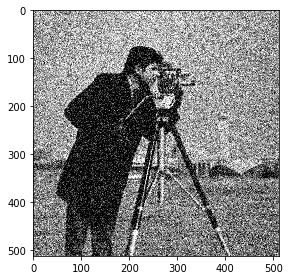

In [6]:
imshow(noisy)

In [7]:
filters = []
width = 5
for scale in [1, 3, 9]:
    base = np.zeros((width, width))
    for i in range(width*width):
        phases = np.unravel_index(i, (width, width))
        if phases[0] == phases[1] and phases[0] == width//2:
            continue
        base = np.zeros((width, width))
        base[phases] = 1
        filters.append(base.repeat(scale, 0).repeat(scale, 1))

In [8]:
x_feat = np.broadcast_to(np.arange(0, noisy.shape[0])[:,np.newaxis], noisy.shape)/noisy.shape[0]
y_feat = np.broadcast_to(np.arange(0, noisy.shape[1])[np.newaxis], noisy.shape)/noisy.shape[1]

In [9]:
features = [ndi.convolve(noisy, f, mode='mirror') for f in filters]
features = np.stack(features, axis = -1)

In [10]:
x = features.reshape(-1, features.shape[-1])
y = noisy.reshape(-1)

# ML Models

In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [12]:
rf = RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=60)
rf.fit(x, y)
z_rf = rf.predict(x)
denoised_rf = z_rf.reshape(image.shape).clip(0,1)
psnr(denoised_rf, image)

25.493963206371824

In [13]:
lm = LinearRegression()
lm = lm.fit(x,y)
z_lm = lm.predict(x)
denoised_lm = z_lm.reshape(image.shape).clip(0,1)
psnr(denoised_lm, image), ssim(denoised_lm, image)

(24.88414858640907, 0.7764955661123953)

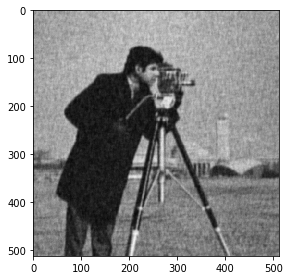

In [14]:
imshow(denoised_lm)

In [15]:
# gb = GradientBoostingRegressor(**{'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
#           'learning_rate': 0.01, 'loss': 'ls'})
# gb.fit(x,y)
# z_gb = gb.predict(x)
# denoised_gb = z_gb.reshape(image.shape).clip(0,1)
# psnr(denoised_gb, image), ssim(denoised_gb, image)

In [16]:
denoised_avg = (denoised_lm + denoised_rf)/2
psnr(denoised_avg, image), ssim(denoised_avg, image)

(25.61051770023646, 0.8352105166018435)

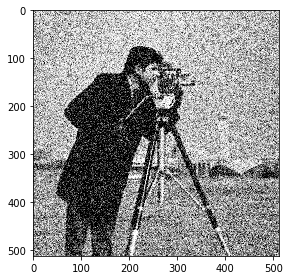

In [17]:
imshow(noisy, cmap='Greys_r')

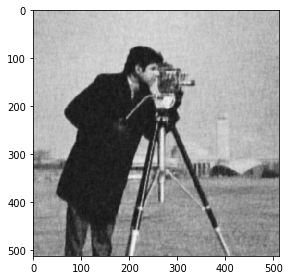

In [18]:
imshow(denoised_avg, cmap='Greys_r')

## Classical

In [19]:
from skimage.restoration import denoise_wavelet
denoised = denoise_wavelet(noisy)
psnr(denoised, image), ssim(denoised, image)

(24.241174965686156, 0.7614099355867538)

In [20]:
from skimage.restoration import denoise_tv_chambolle
denoised = denoise_tv_chambolle(noisy)
psnr(denoised, image), ssim(denoised, image)

(23.54250898049498, 0.6478384656526316)

In [21]:
from skimage.restoration import denoise_nl_means, estimate_sigma
denoised = denoise_nl_means(noisy, sigma = estimate_sigma(noisy), h = estimate_sigma(noisy)*0.6)
psnr(denoised, image), ssim(denoised, image)

/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


(26.150192224614575, 0.8181652000168435)

## Kitchen Sinks

In [22]:
import numpy.linalg as LA
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

def median_dist(X):
    """Compute the approximate median distance by sampling pairs."""
    k = 1<<20  # 1M random points
    i = np.random.randint(0, X.shape[0], k)
    j = np.random.randint(0, X.shape[0], k)
    return np.sqrt(np.median(np.sum((X[i,:] - X[j,:])**2, axis=1)))

def pca(X, dim):
    """Perform centered PCA."""
    X = X - X.mean(axis=0)
    return LA.eigh(X.T.dot(X))[1][:,-dim:]

class KitchenSinks():
    def __init__(self, nonlinearity = 'cosine', latent_dim = 50, n_features = 1000, cat = True, pca = True):
        self.nonlinearity = nonlinearity
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.cat = cat
        self.pca = pca
        
    
        self.W = None
        self.logit = None
    
    def fit(self, X, y):
        np.random.seed(0)
        # we are just gonna work with a low-dimensional projection, 50 effective pixels instead of 784
        if pca:
            V = pca(X, self.latent_dim)
            Xproj = X.dot(V)
        else:
            Xproj = X
        sigma = median_dist(Xproj)
        
        W = np.random.randn(self.latent_dim, self.n_features)/sigma
        b = np.random.uniform(-np.pi, np.pi, self.n_features)
        
        X_red = np.cos(Xproj.dot(W) + b)
        
        if self.cat:
            X_red = np.hstack([X_red, X])
 
        logit = linear_model.LinearRegression()
        logit.fit(X_red, y)

        self.logit = logit
        self.W = W
        self.b = b
        self.V = V
        
    def predict(self, X):
        if pca:
            X_proj = X.dot(self.V)
        else:
            X_proj = X
            
        X_red = np.cos(X_proj.dot(self.W) + self.b)
            
        if self.cat:
            X_red = np.hstack([X_red, X])
            
        return self.logit.predict(X_red)
    
    def score(self, X, y):
        X_red = np.cos(X.dot(self.V).dot(self.W) + self.b)
        
        if self.cat:
            X_red = np.hstack([X_red, X])
            
        return self.logit.score(X_red, y)

In [23]:
ks = KitchenSinks(cat = True, pca = False, n_features = 100)
ks.fit(x,y)
z_ks = ks.predict(x)
denoised_ks = z_ks.reshape(image.shape).clip(0,1)
psnr(denoised_ks, image), ssim(denoised_ks, image)

(24.92944242825359, 0.7784436498826058)

In [24]:
ks = KitchenSinks(cat = True, pca = False, n_features = 400)
ks.fit(x,y)
z_ks = ks.predict(x)
denoised_ks = z_ks.reshape(image.shape).clip(0,1)
psnr(denoised_ks, image), ssim(denoised_ks, image)

(25.12213967456923, 0.7900305294459532)

In [25]:
ks = KitchenSinks(cat = True, pca = False, n_features = 1000)
ks.fit(x,y)
z_ks = ks.predict(x)
denoised_ks = z_ks.reshape(image.shape).clip(0,1)
psnr(denoised_ks, image), ssim(denoised_ks, image)

(25.496530695855487, 0.810854212150189)

In [26]:
ks = KitchenSinks(cat = True, pca = False, n_features = 2000)
ks.fit(x,y)
z_ks = ks.predict(x)
denoised_ks = z_ks.reshape(image.shape).clip(0,1)
psnr(denoised_ks, image), ssim(denoised_ks, image)

(25.865412888060654, 0.8270458277829297)

## XGBoost

In [27]:
import xgboost as xgb

In [28]:
dtrain = xgb.DMatrix(data=x, label=y)
param = {'booster':'gblinear'}

In [29]:
model = xgb.XGBRegressor(depth=6, n_jobs=3).fit(x[::],y[::])

In [30]:
z = model.predict(x)
denoised = z.reshape(-1,512).clip(0,1)
psnr(denoised, image), ssim(denoised, image)

/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


(25.69434208755095, 0.8292564158442716)

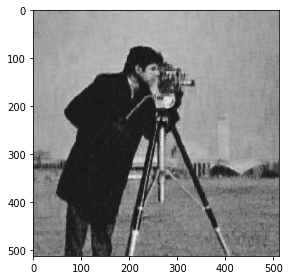

In [31]:
imshow(denoised)

In [32]:
av_denoised = (denoised + denoised_lm)/2
psnr(av_denoised, image)

25.563781246510597